## Representación de baja dimension + Clustering

In [1]:

import fastf1 as ff1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score

from src import preprocessing  


#### 1. Creo un CSV nuevo de representación (Mónaco 2025, carrera, TODOS los pilotos)

1.1. Descargo y limpiar datos FastF1

In [2]:
ff1.Cache.enable_cache("./cache")

year = 2025
gp_name = "Monaco Grand Prix"
session_code = "R"   # Race

session = ff1.get_session(year, gp_name, session_code)
session.load()

laps = session.laps.copy()

print("Columnas de laps:")
print(laps.columns)
print("Cantidad de vueltas totales:", len(laps))


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']


Columnas de laps:
Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')
Cantidad de vueltas totales: 1425


1.2. Filtrar vueltas “útiles”

In [3]:
df_rep = laps.copy()

# Filtro por LapTime válido
df_rep = df_rep[df_rep["LapTime"].notna()].copy()

# Filtro vueltas borradas si existe la columna
if "Deleted" in df_rep.columns:
    df_rep = df_rep[~df_rep["Deleted"]].copy()

# Agregar LapTime_s
df_rep["LapTime_s"] = df_rep["LapTime"].dt.total_seconds()

# Agregar Session = "RACE" (para que sea compatible con add_basic_features)
df_rep["Session"] = "RACE"

# Nos quedamos con columnas relevantes
cols_keep = [
    "Driver", "DriverNumber", "Team",
    "LapNumber", "Stint", "TyreLife", "Compound",
    "LapTime", "LapTime_s", "TrackStatus",
    "PitOutTime", "PitInTime",
    "Sector1Time", "Sector2Time", "Sector3Time",
    "SpeedI1", "SpeedI2", "SpeedFL", "SpeedST",
]
cols_keep = [c for c in cols_keep if c in df_rep.columns]

df_rep = df_rep[cols_keep].copy()
print("Vueltas después de filtros:", len(df_rep))
df_rep.head()


Vueltas después de filtros: 1409


,Driver,DriverNumber,Team,LapNumber,Stint,TyreLife,Compound,LapTime,LapTime_s,TrackStatus,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST
0,VER,1,Red Bull Racing,1.0,1.0,1.0,HARD,0 days 00:01:27.020000,87.020,12,NaT,NaT,NaT,0 days 00:00:38.394000,0 days 00:00:21.759000,170.0,178.0,253.0,258.0
1,VER,1,Red Bull Racing,2.0,1.0,2.0,HARD,0 days 00:01:46.318000,106.318,16,NaT,NaT,0 days 00:00:34.949000,0 days 00:00:45.145000,0 days 00:00:26.224000,83.0,167.0,229.0,254.0
2,VER,1,Red Bull Racing,3.0,1.0,3.0,HARD,0 days 00:01:48.815000,108.815,6,NaT,NaT,0 days 00:00:32.110000,0 days 00:00:47.430000,0 days 00:00:29.275000,159.0,100.0,226.0,257.0
3,VER,1,Red Bull Racing,4.0,1.0,4.0,HARD,0 days 00:01:40.290000,100.290,671,NaT,NaT,0 days 00:00:31.006000,0 days 00:00:47.889000,0 days 00:00:21.395000,136.0,170.0,262.0,253.0
4,VER,1,Red Bull Racing,5.0,1.0,5.0,HARD,0 days 00:01:20.800000,80.800,1,NaT,NaT,0 days 00:00:21.744000,0 days 00:00:37.485000,0 days 00:00:21.571000,177.0,173.0,254.0,262.0


1.3. Aplico nuestro feature engineering v2

In [4]:
df_rep_fe = preprocessing.add_basic_features(df_rep)

print("Columnas después de FE v2:")
print(df_rep_fe.columns)
print("Vueltas finales:", len(df_rep_fe))


Columnas después de FE v2:
Index(['Driver', 'DriverNumber', 'Team', 'LapNumber', 'Stint', 'TyreLife',
       'Compound', 'LapTime', 'LapTime_s', 'TrackStatus', 'PitOutTime',
       'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
       'SpeedI2', 'SpeedFL', 'SpeedST', 'compound_order'],
      dtype='object')
Vueltas finales: 1409


1.4. Guardao el CSV de representación

In [5]:
out_path = "data/processed/monaco_2025_race_all_drivers_rep.csv"
df_rep_fe.to_csv(out_path, index=False)
print("Guardado CSV de representación en:", out_path)


Guardado CSV de representación en: data/processed/monaco_2025_race_all_drivers_rep.csv


#### 2. Cargar CSV y preparar X para PCA / Autoencoder

In [6]:
df = pd.read_csv("data/processed/monaco_2025_race_all_drivers_rep.csv")

print(df.shape)
df.head()


(1409, 20)


,Driver,DriverNumber,Team,LapNumber,Stint,TyreLife,Compound,LapTime,LapTime_s,TrackStatus,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,compound_order
0,VER,1,Red Bull Racing,1.0,1.0,1.0,HARD,0 days 00:01:27.020000,87.020,12,NaN,NaN,NaN,0 days 00:00:38.394000,0 days 00:00:21.759000,170.0,178.0,253.0,258.0,2.0
1,VER,1,Red Bull Racing,2.0,1.0,2.0,HARD,0 days 00:01:46.318000,106.318,16,NaN,NaN,0 days 00:00:34.949000,0 days 00:00:45.145000,0 days 00:00:26.224000,83.0,167.0,229.0,254.0,2.0
2,VER,1,Red Bull Racing,3.0,1.0,3.0,HARD,0 days 00:01:48.815000,108.815,6,NaN,NaN,0 days 00:00:32.110000,0 days 00:00:47.430000,0 days 00:00:29.275000,159.0,100.0,226.0,257.0,2.0
3,VER,1,Red Bull Racing,4.0,1.0,4.0,HARD,0 days 00:01:40.290000,100.290,671,NaN,NaN,0 days 00:00:31.006000,0 days 00:00:47.889000,0 days 00:00:21.395000,136.0,170.0,262.0,253.0,2.0
4,VER,1,Red Bull Racing,5.0,1.0,5.0,HARD,0 days 00:01:20.800000,80.800,1,NaN,NaN,0 days 00:00:21.744000,0 days 00:00:37.485000,0 days 00:00:21.571000,177.0,173.0,254.0,262.0,2.0


2.1. Definir qué features usar para la representación

In [7]:
# Set "estratégico" (solo features sin fuga, coherentes con el modelo de LapTime)
NUM_FEATURES_STRATEGIC = [
    "LapNumber",
    "Stint",
    "TyreLife",
    "lap_norm_session",
    "compound_order",
]

CAT_FEATURES_STRATEGIC = [
    "Session",   # va a ser "RACE" en este CSV, pero lo dejamos para generalizar
    "Compound",
]

NUM_FEATURES_STRATEGIC = [c for c in NUM_FEATURES_STRATEGIC if c in df.columns]
CAT_FEATURES_STRATEGIC = [c for c in CAT_FEATURES_STRATEGIC if c in df.columns]

# Labels para colorear / analizar
label_driver = df["Driver"].to_numpy()
label_team   = df["Team"].to_numpy()
label_comp   = df["Compound"].to_numpy()


2.2. Preprocesar para representación (matriz numérica densa)

In [8]:
from sklearn.pipeline import Pipeline

preprocess_rep = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES_STRATEGIC),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES_STRATEGIC),
    ]
)

# Pipeline solo de preprocesado
pipe_rep = Pipeline(steps=[
    ("preprocess", preprocess_rep),
])

X_rep = pipe_rep.fit_transform(df)

if hasattr(X_rep, "toarray"):
    X_rep = X_rep.toarray()

X_rep.shape


(1409, 7)

#### 3. PCA: representación 2D y gráficos

3.1. Ajustar PCA

In [9]:
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_rep)

print("Varianza explicada por componente:")
print(pca.explained_variance_ratio_)
print("Varianza explicada acumulada:", pca.explained_variance_ratio_.cumsum())


Varianza explicada por componente:
[0.43199789 0.33149372 0.17822674 0.03051572 0.02776594]
Varianza explicada acumulada: [0.43199789 0.76349161 0.94171835 0.97223406 1.        ]


3.2. Función de scatter 2D color por etiqueta

In [10]:
def plot_latent_2d(Z, labels, title="", figsize=(6, 5), alpha=0.7, legend_fontsize=9):
    plt.figure(figsize=figsize)
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        mask = labels == lab
        plt.scatter(
            Z[mask, 0],
            Z[mask, 1],
            label=str(lab),
            alpha=alpha,
            s=20,
        )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend(loc="upper left", fontsize=legend_fontsize, markerscale=1.5, framealpha=0.9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


3.3. Gráficos:

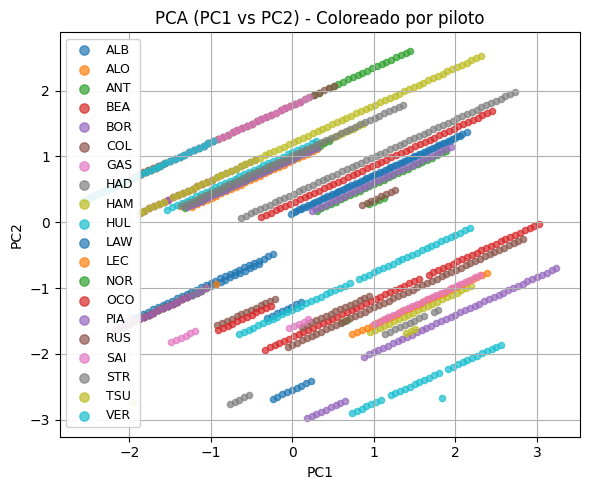

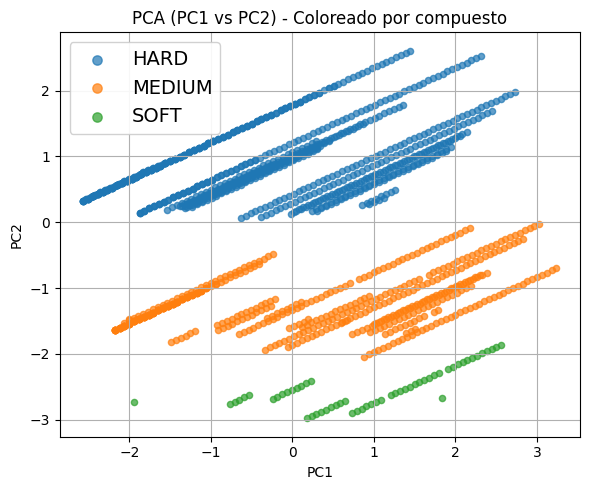

In [11]:
Z2 = X_pca[:, :2]  # PC1, PC2

# Por piloto
plot_latent_2d(
    Z2,
    label_driver,
    title="PCA (PC1 vs PC2) - Coloreado por piloto",
    legend_fontsize=9
)

# Por compuesto
plot_latent_2d(
    Z2,
    label_comp,
    title="PCA (PC1 vs PC2) - Coloreado por compuesto",
    legend_fontsize=14
)


#### 4. Clustering (k-means) + métricas de estructura

4.1. k-means en el espacio PCA

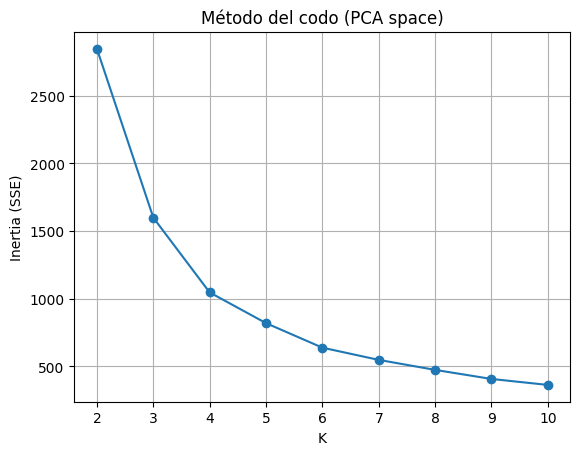

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Ks = range(2, 11)
inertias = []

for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(Z2)  
    inertias.append(kmeans.inertia_)

plt.plot(Ks, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (SSE)")
plt.title("Método del codo (PCA space)")
plt.grid(True)
plt.show()


Elegimos K=4 por el metodo del Elbow.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, adjusted_rand_score

K = 4 # Elegido por nosotros según el elbow

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(Z2)

sil = silhouette_score(Z2, clusters)
hom_driver = homogeneity_score(label_driver, clusters)
hom_team   = homogeneity_score(label_team, clusters)
hom_comp   = homogeneity_score(label_comp, clusters)

print(f"K={K}")
print(f"Silhouette: {sil:.3f}")
print(f"Homogeneidad respecto a Driver: {hom_driver:.3f}")
print(f"Homogeneidad respecto a Team:   {hom_team:.3f}")
print(f"Homogeneidad respecto a Compound:{hom_comp:.3f}")


K=4
Silhouette: 0.485
Homogeneidad respecto a Driver: 0.141
Homogeneidad respecto a Team:   0.101
Homogeneidad respecto a Compound:0.842


4.2. Visualizacion de los clusters

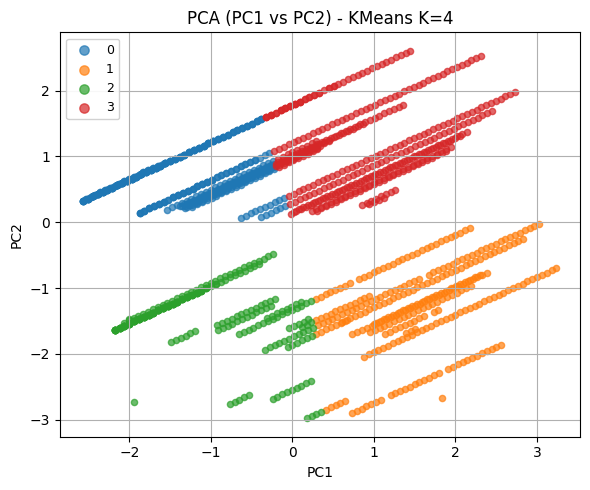

In [14]:
plot_latent_2d(
    Z2,
    clusters,
    title=f"PCA (PC1 vs PC2) - KMeans K={K}"
)


#### 5. Autoencoder: representación no lineal

5.1. Defino el modelo

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_rep.shape[1]
latent_dim = 2  # para graficar fácil en 2D

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z


5.2. Entrenamiento del Autoencoder

In [16]:
X_tensor = torch.tensor(X_rep, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

ae = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 100

for epoch in range(1, n_epochs + 1):
    ae.train()
    epoch_loss = 0.0
    for (batch_x,) in loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        x_rec, z = ae(batch_x)
        loss = criterion(x_rec, batch_x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs} - Recon loss: {epoch_loss:.6f}")


Epoch 10/100 - Recon loss: 0.058683
Epoch 20/100 - Recon loss: 0.030511
Epoch 30/100 - Recon loss: 0.023774
Epoch 40/100 - Recon loss: 0.018989
Epoch 50/100 - Recon loss: 0.015615
Epoch 60/100 - Recon loss: 0.013463
Epoch 70/100 - Recon loss: 0.011989
Epoch 80/100 - Recon loss: 0.010579
Epoch 90/100 - Recon loss: 0.009436
Epoch 100/100 - Recon loss: 0.008407


5.3. Obtengo la representación latente Z_ae

In [17]:
ae.eval()
with torch.no_grad():
    X_tensor = X_tensor.to(device)
    _, Z_ae = ae(X_tensor)
    Z_ae = Z_ae.cpu().numpy()

Z_ae.shape  # (n_laps, latent_dim)


(1409, 2)

5.4. Gráficos y clustering en el espacio del AE

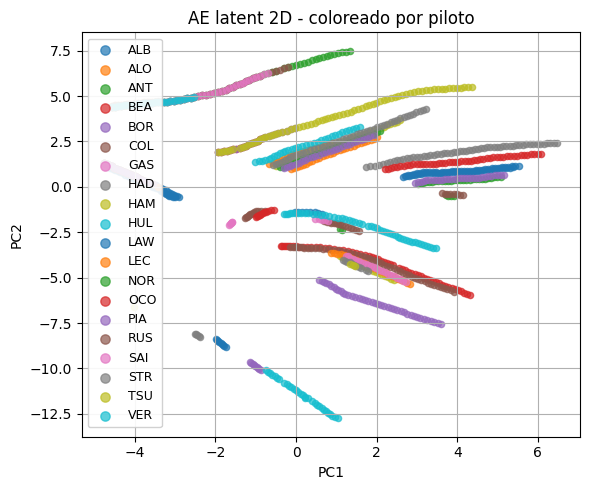

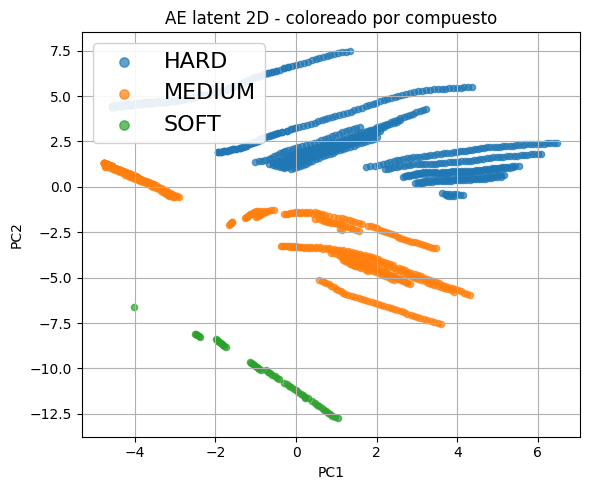

[AE] K=4
Silhouette: 0.493
Homogeneidad Driver:   0.183
Homogeneidad Team:     0.140
Homogeneidad Compound: 0.657


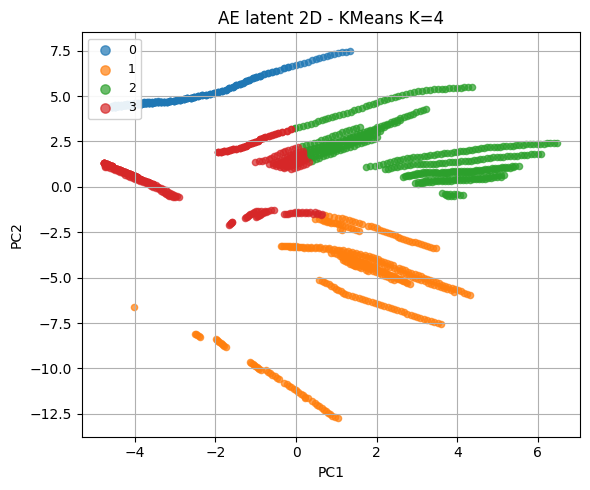

In [18]:
# Por piloto
plot_latent_2d(Z_ae, label_driver, title="AE latent 2D - coloreado por piloto" ,legend_fontsize=9)

# Por compuesto
plot_latent_2d(Z_ae, label_comp, title="AE latent 2D - coloreado por compuesto", legend_fontsize=16)

# Clustering en el espacio del AE
kmeans_ae = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters_ae = kmeans_ae.fit_predict(Z_ae)

sil_ae = silhouette_score(Z_ae, clusters_ae)
hom_driver_ae = homogeneity_score(label_driver, clusters_ae)
hom_team_ae   = homogeneity_score(label_team, clusters_ae)
hom_comp_ae   = homogeneity_score(label_comp, clusters_ae)

print(f"[AE] K={K}")
print(f"Silhouette: {sil_ae:.3f}")
print(f"Homogeneidad Driver:   {hom_driver_ae:.3f}")
print(f"Homogeneidad Team:     {hom_team_ae:.3f}")
print(f"Homogeneidad Compound: {hom_comp_ae:.3f}")

# Visualizar clusters del AE
plot_latent_2d(Z_ae, clusters_ae, title=f"AE latent 2D - KMeans K={K}")


#### 6. Separacion entre Vueltas Rapidas vs Lentas:

6.1. Hacemos K-Means sobre los tiempos de vuelta (K=2)

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 1D: solo el tiempo de vuelta en segundos
lap_times = df["LapTime_s"].values.reshape(-1, 1)

kmeans_pace = KMeans(n_clusters=2, random_state=42, n_init=10)
pace_clusters = kmeans_pace.fit_predict(lap_times)

# Medias de LapTime en cada cluster
cluster_means = []
for k in range(2):
    mean_k = lap_times[pace_clusters == k].mean()
    cluster_means.append(mean_k)
    print(f"Cluster {k}: mean LapTime_s = {mean_k:.3f} s")

# Identifico cuál es el cluster "rápido"
fast_cluster_id = int(np.argmin(cluster_means))
slow_cluster_id = 1 - fast_cluster_id

print(f"\nCluster rápido  : {fast_cluster_id}")
print(f"Cluster lento   : {slow_cluster_id}")

# Creo columna con etiquetas legibles
pace_labels = np.where(pace_clusters == fast_cluster_id, "FAST", "SLOW")
df["pace_cluster"] = pace_labels

# Silhouette para ver qué tan separados están
sil = silhouette_score(lap_times, pace_clusters)
print(f"\nSilhouette score (K=2, LapTime_s): {sil:.3f}")
print(df["pace_cluster"].value_counts())


Cluster 0: mean LapTime_s = 77.557 s
Cluster 1: mean LapTime_s = 101.368 s

Cluster rápido  : 0
Cluster lento   : 1

Silhouette score (K=2, LapTime_s): 0.871
pace_cluster
FAST    1303
SLOW     106
Name: count, dtype: int64


6.2. Histograma de tiempos rápidos vs lentos

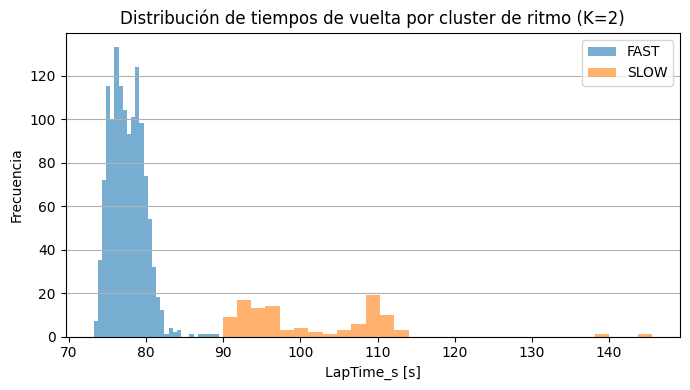

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
for label, color in [("FAST", "tab:green"), ("SLOW", "tab:red")]:
    subset = df[df["pace_cluster"] == label]["LapTime_s"]
    plt.hist(subset, bins=30, alpha=0.6, label=label)

plt.xlabel("LapTime_s [s]")
plt.ylabel("Frecuencia")
plt.title("Distribución de tiempos de vuelta por cluster de ritmo (K=2)")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()


6.3. Veamos dónde caen FAST/SLOW en el espacio PCA

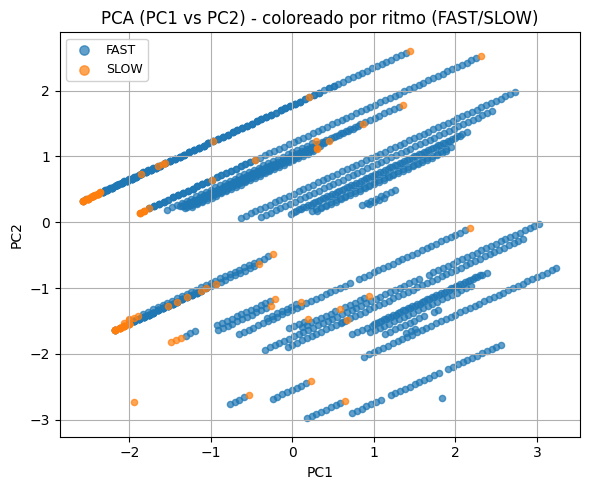

In [21]:
plot_latent_2d(
    Z2,
    df["pace_cluster"].values,
    title="PCA (PC1 vs PC2) - coloreado por ritmo (FAST/SLOW)"
)


6.4. Lo mismo pero en el espacio del Autoencoder

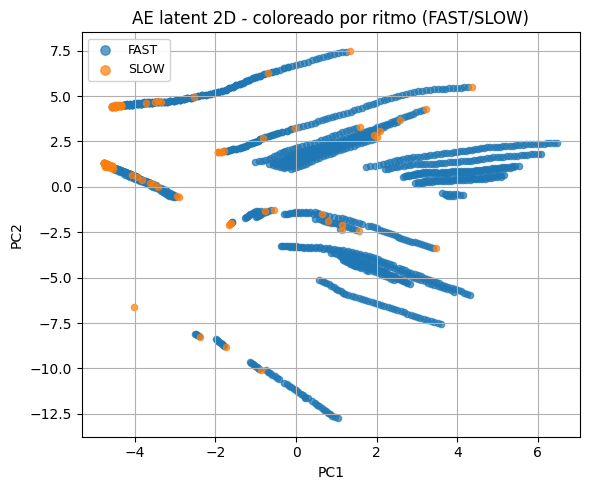

In [22]:
plot_latent_2d(
    Z_ae,
    df["pace_cluster"].values,
    title="AE latent 2D - coloreado por ritmo (FAST/SLOW)"
)
